# Arena Class Examples

## In this notebook, we provide examples to create arenas so an agent can interact with.
Each of these arenas has common methods that resemble Open AI gym structure (soon we will built our classes on top of Open AI gym environments).
The package has methods to build 2D arenas with arbitrary shapes described by "walls" that can be easely change for each arena. There are also arenas that resemble sampling rate and dimensions of specific experiments (see "Experiment Class Example" notebook), one using these arenas, the experimental data (animal trajectory and neural recording) is loaded from its respective dataset, and can be used to compare results againts the artificial agent.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt

First, let's initialize a random agent to evaluate on each envirnoment

In [2]:
from neuralplayground.agents import RandomAgent
agent = RandomAgent()

## 2D arenas

These arenas are maleable and can take arbitrary shapes based on the configuration its walls. Here we start by a default square room.

In [3]:
from neuralplayground.arenas import Simple2D, ConnectedRooms

We initialize the arena/environment

In [4]:
env_name = "env_example"
time_step_size = 0.1 #seg
agent_step_size = 3

# Init environment
env = Simple2D(time_step_size = time_step_size,
               agent_step_size = agent_step_size,
               arena_x_limits=(-100, 100), 
               arena_y_limits=(-100, 100))

For all arenas

In [5]:
n_steps = 5000

# Initialize environment
obs, state = env.reset()
for i in range(n_steps):
    # Observe to choose an action
    action = agent.act(obs)
    # Run environment for given action
    obs, state, reward = env.step(action)

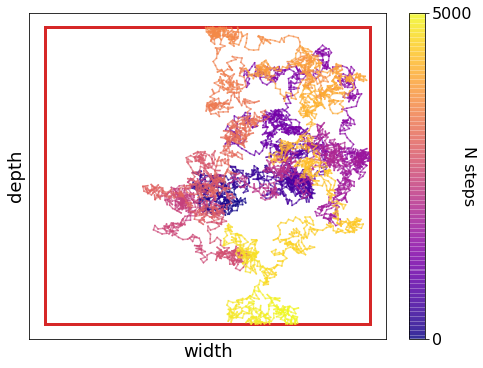

In [6]:
ax = env.plot_trajectory()
fontsize = 18
ax.grid()
# ax.legend(fontsize=fontsize, loc="upper left")
ax.set_xlabel("width", fontsize=fontsize)
ax.set_ylabel("depth", fontsize=fontsize)
# plt.savefig("two_rooms.pdf", bbox_inches="tight")
plt.show()